In [48]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, \
f1_score
import xgboost as xgb
from scipy.stats import randint, uniform
import numpy as np


In [2]:
data  = pd.read_csv(r"../data/gd.csv")

In [3]:
data.head()

,Account_status,Duration_months,Credit_history,loan_Purpose,Credit_amount,Savings/Bonds_AC,Present_Employment_since,loan_wage_ratio,Sex,Marital_status,...,Assets/Physical_property,Age,Other_loans,Housing,Existing Credit,Job_status,Dependents,Telephone,Foreign_worker,Credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,Male,single,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,Female,divorced/separated/married,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,Male,single,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,Male,single,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,Male,single,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
data.columns

Index(['Account_status', 'Duration_months', 'Credit_history', 'loan_Purpose',
       'Credit_amount', 'Savings/Bonds_AC', 'Present_Employment_since',
       'loan_wage_ratio', 'Sex', 'Marital_status', 'co-debtors', 'Tenure',
       'Assets/Physical_property', 'Age', 'Other_loans', 'Housing',
       'Existing Credit', 'Job_status', 'Dependents', 'Telephone',
       'Foreign_worker', 'Credit_risk'],
      dtype='object')

In [5]:
data['Credit_risk'] = data['Credit_risk'].map({2:1, 1:0})

In [6]:
data.head()

,Account_status,Duration_months,Credit_history,loan_Purpose,Credit_amount,Savings/Bonds_AC,Present_Employment_since,loan_wage_ratio,Sex,Marital_status,...,Assets/Physical_property,Age,Other_loans,Housing,Existing Credit,Job_status,Dependents,Telephone,Foreign_worker,Credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,Male,single,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,Female,divorced/separated/married,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,Male,single,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,Male,single,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,Male,single,...,A124,53,A143,A153,2,A173,2,A191,A201,1


<pre>

>> For XGBoostClassifier, we requires a binary format targer values, so that's why we are changing Credit Risk to 0 and 1.



In [7]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Account_status            1000 non-null   object
 1   Duration_months           1000 non-null   int64 
 2   Credit_history            1000 non-null   object
 3   loan_Purpose              1000 non-null   object
 4   Credit_amount             1000 non-null   int64 
 5   Savings/Bonds_AC          1000 non-null   object
 6   Present_Employment_since  1000 non-null   object
 7   loan_wage_ratio           1000 non-null   int64 
 8   Sex                       1000 non-null   object
 9   Marital_status            1000 non-null   object
 10  co-debtors                1000 non-null   object
 11  Tenure                    1000 non-null   int64 
 12  Assets/Physical_property  1000 non-null   object
 13  Age                       1000 non-null   int64 
 14  Other_loans              

In [10]:
ordinal_categories = [
    ["A61", "A62", "A63", "A64", "A65"], 
    ["A71", "A72", "A73", "A74", "A75"], 
    ["A124", "A123", "A122", "A121"], 
    ["A171", "A172", "A173", "A174"]
]


ohe_columns = ["Account_status", "Credit_history", "loan_Purpose", "Sex", 
               "Marital_status", "co-debtors", "Other_loans", "Housing", 
               "Dependents", "Telephone", "Foreign_worker"]
rob_scaling = ["Duration_months", "Credit_amount", "Age"]
ord_enc = ["Savings/Bonds_AC", "Present_Employment_since", "Assets/Physical_property", 
           "Job_status"]




In [11]:
ct = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"), ohe_columns), 
        ("scale", RobustScaler(), rob_scaling), 
        ("enc", OrdinalEncoder(categories=ordinal_categories), ord_enc)
    ], 
    remainder="passthrough"
)

In [12]:
y_train.value_counts()

Credit_risk
0    448
1    192
Name: count, dtype: int64

<pre>

We will do SMOTE technique to balance the dataset.



In [13]:
base_pipeline = Pipeline(
    [
        ("preprocess", ct), 
        # ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), 
        ("smote", SMOTE(random_state=42)), 
        ("model", XGBClassifier(
            tree_method = "hist",
            # eval_metric = "logloss",
            # early_stopping_rounds = 50
        ))
    ]
)

In [14]:
param_grid_xgb = {
    "model__learning_rate": [0.01, 0.05, 0.1], 
    "model__max_depth": [3, 5, 7, 10], 
    "model__n_estimators": [100, 300, 500, 1000]

}

In [15]:
XGB_gs = GridSearchCV(
    estimator=base_pipeline, 
    param_grid = param_grid_xgb, 
    scoring = "recall", 
    cv = 5, 
    n_jobs = 4, 
    verbose = 2
)

In [16]:
XGB_gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [3, 5, ...], 'model__n_estimators': [100, 300, ...]}"
,scoring,'recall'
,n_jobs,4
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('scale', ...), ...]"


In [17]:
XGB_gs.best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [18]:
XGB_gs.best_score_

np.float64(0.7233468286099866)

In [19]:
test_pred_xgb =  XGB_gs.predict(X_test)
train_pred_xgb = XGB_gs.predict(X_train)

In [20]:
accuracy_score(y_test, test_pred_xgb)

0.695

In [21]:
accuracy_score(y_train, train_pred_xgb)

0.7546875

In [22]:
print(classification_report(y_test, test_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.67      0.76       140
           1       0.49      0.75      0.60        60

    accuracy                           0.69       200
   macro avg       0.68      0.71      0.68       200
weighted avg       0.75      0.69      0.71       200



<pre>

- My Recall for Bad Credit is 0.82, which is decent, 
- As I don't want to miss any Bad Credit, but I want to achienve it more, 
- So, let's tune our model again, even at the cost of Flase Positive, which is what a Bank Manager would desire for.

>> Also, this GridSearchCV is so expensive, that we may not want that, 
   instead we will go with randomizedsearchcv.



In [25]:
y_scores = XGB_gs.predict_proba(X_test)[:, 1]

In [ ]:
precision, recall, thresholds  = precision_recall_curve(y_test, y_scores)   

In [42]:
y_scores

array([0.49312937, 0.41367015, 0.6849573 , 0.6452837 , 0.44265738,
       0.47830975, 0.5327648 , 0.53360134, 0.6413253 , 0.49540302,
       0.23566313, 0.4674465 , 0.23566313, 0.23566313, 0.5112697 ,
       0.23566313, 0.5586316 , 0.23841912, 0.2522035 , 0.23566313,
       0.23841912, 0.23566313, 0.23841912, 0.67841136, 0.59210443,
       0.56459415, 0.23566313, 0.4779665 , 0.2705565 , 0.23566313,
       0.37324518, 0.50205594, 0.23566313, 0.6562208 , 0.2522035 ,
       0.6849573 , 0.67841136, 0.6849573 , 0.4182259 , 0.6653966 ,
       0.7149737 , 0.6078075 , 0.5064456 , 0.49437073, 0.4752553 ,
       0.23566313, 0.7149737 , 0.51372015, 0.55403674, 0.3784932 ,
       0.23566313, 0.23566313, 0.5420017 , 0.6078075 , 0.63834864,
       0.5365195 , 0.23841912, 0.4409461 , 0.56459415, 0.67841136,
       0.33651936, 0.7149737 , 0.47820854, 0.6562208 , 0.23566313,
       0.43905511, 0.23566313, 0.23566313, 0.6562208 , 0.6078075 ,
       0.56510603, 0.63834864, 0.23566313, 0.4921806 , 0.50205

In [43]:
thresholds

array([0.23566313, 0.23841912, 0.24354693, 0.2522035 , 0.26428583,
       0.2705565 , 0.27338767, 0.3080034 , 0.31318906, 0.33651936,
       0.35907248, 0.37324518, 0.3784932 , 0.38343114, 0.3852128 ,
       0.38536492, 0.40978804, 0.41042262, 0.4111644 , 0.41367015,
       0.4182259 , 0.4283929 , 0.43905511, 0.44007716, 0.4409461 ,
       0.44265738, 0.4459364 , 0.4564466 , 0.4609121 , 0.46521473,
       0.467022  , 0.4674465 , 0.46797025, 0.47135052, 0.47168118,
       0.47427446, 0.4752553 , 0.4755631 , 0.47720885, 0.4779665 ,
       0.47820854, 0.47830975, 0.4893304 , 0.4921806 , 0.49312937,
       0.49437073, 0.49540302, 0.50205594, 0.5064456 , 0.5112697 ,
       0.51372015, 0.5283771 , 0.53218985, 0.5327648 , 0.53360134,
       0.5365195 , 0.53906155, 0.5396727 , 0.54000854, 0.5420017 ,
       0.543962  , 0.5453594 , 0.5471566 , 0.54743665, 0.5481001 ,
       0.55168605, 0.55403674, 0.55861676, 0.5586316 , 0.56459415,
       0.56510603, 0.56544405, 0.57346195, 0.57581097, 0.57595

In [34]:
precision

array([0.3       , 0.34756098, 0.36601307, 0.37333333, 0.38194444,
       0.38732394, 0.39285714, 0.39568345, 0.39130435, 0.39416058,
       0.38970588, 0.39393939, 0.39694656, 0.39534884, 0.3984375 ,
       0.39370079, 0.3968254 , 0.4       , 0.40322581, 0.40650407,
       0.40983607, 0.41322314, 0.42372881, 0.42735043, 0.43103448,
       0.43478261, 0.42982456, 0.43362832, 0.4375    , 0.43636364,
       0.44036697, 0.44444444, 0.43925234, 0.42857143, 0.43269231,
       0.4368932 , 0.44117647, 0.44554455, 0.45      , 0.45454545,
       0.45918367, 0.46391753, 0.46875   , 0.47368421, 0.4787234 ,
       0.48387097, 0.48913043, 0.49450549, 0.49438202, 0.51162791,
       0.50588235, 0.48780488, 0.5       , 0.49367089, 0.5       ,
       0.50649351, 0.50666667, 0.51351351, 0.50684932, 0.51388889,
       0.52112676, 0.51428571, 0.52173913, 0.52941176, 0.53731343,
       0.53030303, 0.52307692, 0.53125   , 0.52380952, 0.53225806,
       0.55172414, 0.54385965, 0.55357143, 0.56363636, 0.57407

In [31]:
len(thresholds)

97

In [32]:
len(recall)

98

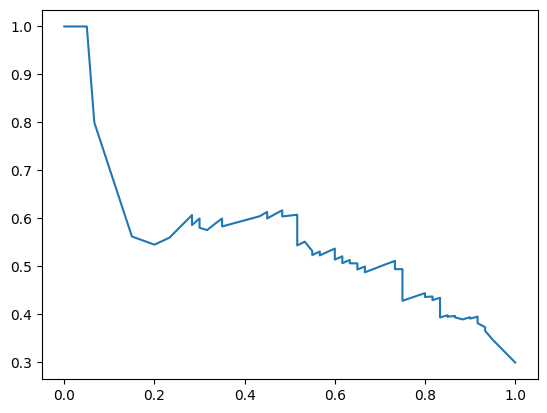

In [44]:
plt.plot(recall, precision)

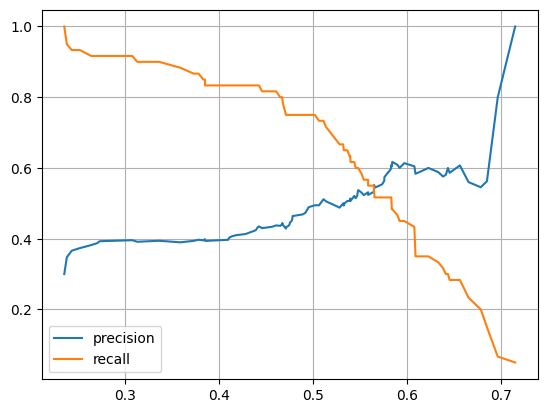

In [63]:
plt.plot(thresholds, precision[:-1], label="precision")
plt.plot(thresholds, recall[:-1], label ="recall")
plt.legend()
plt.grid(True)

In [54]:
f1list = []
for i in thresholds:
    f1_pred = (y_scores>=i).astype('int')
    f1 = f1_score(y_test, f1_pred)
    f1list.append(f1)


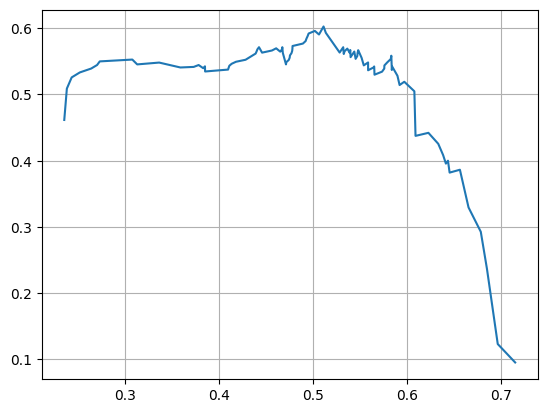

In [57]:
plt.plot(thresholds, f1list)
plt.grid(True)

In [58]:
np.argmax(f1list)

np.int64(49)

In [59]:
thresholds[49]

np.float32(0.5112697)

In [60]:
f1list[49]

0.6027397260273972

In [61]:
recall[50]

np.float64(0.7166666666666667)

In [62]:
precision[50]

np.float64(0.5058823529411764)

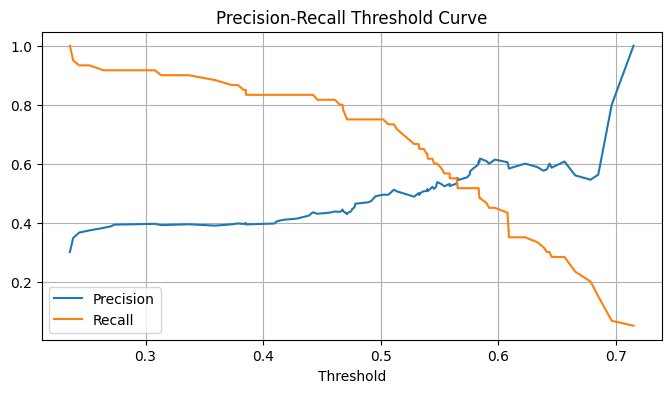

In [67]:
## Write the code for plotting a Precision Recall curve 


y_scores = XGB_gs.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)


plt.figure(figsize = (8, 4))
plt.plot(thresholds, precision[:-1], label = "Precision")
plt.plot(thresholds, recall[:-1], label = 'Recall')
plt.legend()
plt.title("Precision-Recall Threshold Curve")
plt.grid(True)
plt.xlabel("Threshold")
plt.show()

In [105]:
np.argwhere(recall[1:]>.85)[-1][0]

np.int64(11)

In [111]:
np.where(recall[1:]>0.85)[0][-1]

np.int64(11)

In [102]:
thresholds[11]

np.float32(0.37324518)

np.float64(1.0)

In [195]:
new_param_xgb = {
    "model__n_estimators": randint(100, 1000), 
    "model__learning_rate": uniform(0.01, 0.1), 
    "model__max_depth": randint(7, 10), 
    "model__min_child_weight": randint(1, 10), 
    "model__gamma": uniform(0, 0.5), 
    "model__subsample": uniform(0.6, 0.4), 
    "model__colsample_bytree": uniform(0.7, 0.3), 
    "model__scale_pos_weight": uniform(2, 1)
}

In [ ]:
# new_param_xgb = {
#     "model__scale_pos_weight": [1, 1.5, 1.2, 2, 1.8], 
#     "model__max_depth": [4, 5, 6, 7, 8], 
#     "model__min_child_weight": [1, 2, 3], 
#     "model__gamma": [0, 0.1, 0.5], 
#     "model__learning_rate": [0.01, 0.1, 0.05], 
#     "model__n_estimators": [300, 500, 800], 
#     "model__subsample": [0.8, 1.0], 
#     "model__colsample_bytree": [0.8, 1.0]
}

In [ ]:
# XGB_gs = GridSearchCV(
#     estimator=base_pipeline, 
#     param_grid = new_param_xgb, 
#     scoring = "recall", 
#     cv = 5, 
#     n_jobs = -1, 
#     verbose = 2
# )

In [39]:
# XGB_gs.fit(X_train, y_train)

In [104]:
fit_params = {
    "model__eval_set": [(X_val, y_val)], 
    # "model__eval_metric": "logloss", 
    # "model__early_stopping_rounds": 50, 
    "model__verbose": False
}

In [196]:
random_xgb = RandomizedSearchCV(
    estimator = base_pipeline, 
    param_distributions  = new_param_xgb, 
    scoring = "recall", 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
    n_jobs=-1, 
    random_state=42, 
    verbose=3, 
    n_iter = 300, 
)

In [197]:
random_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__colsample_bytree': <scipy.stats....0021CFF98B9D0>, 'model__gamma': <scipy.stats....0021CFF988D00>, 'model__learning_rate': <scipy.stats....0021CFF98A680>, 'model__max_depth': <scipy.stats....0021CFF98BC40>, ...}"
,n_iter,300
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [198]:
random_xgb.best_score_

np.float64(0.8485829959514171)

In [199]:
xgb_test2_pred = random_xgb.predict(X_test)

In [200]:
accuracy_score(y_test, xgb_test2_pred)

0.635

In [201]:
random_xgb.best_params_

{'model__colsample_bytree': np.float64(0.7007018171877334),
 'model__gamma': np.float64(0.4838496941035432),
 'model__learning_rate': np.float64(0.010525381855838492),
 'model__max_depth': 9,
 'model__min_child_weight': 5,
 'model__n_estimators': 143,
 'model__scale_pos_weight': np.float64(2.8074302518167613),
 'model__subsample': np.float64(0.9848395143056471)}

In [202]:
print(classification_report(y_test, xgb_test2_pred))

              precision    recall  f1-score   support

           0       0.89      0.54      0.68       140
           1       0.44      0.85      0.58        60

    accuracy                           0.64       200
   macro avg       0.67      0.70      0.63       200
weighted avg       0.76      0.64      0.65       200



<pre>

>> We can clearly see an improvement in the Recall of Bad Credit Risk Customers: 0.85, 

>> Now, we will try lightgbm as well, then will deploy it!



In [203]:
from lightgbm import LGBMClassifier

In [176]:
lgbm_pipeline = Pipeline([
    ("preprocess", ct), 
    ("smote", SMOTE(random_state=47)), 
    ("model", LGBMClassifier(
        n_estimators = 500, 
        learning_rate = 0.05, 
        max_depth = -1, 
        random_state = 47
    ))
])

In [177]:
param_lgb = {
    "model__n_estimators": randint(100, 1000),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__max_depth": randint(3, 12),
    "model__num_leaves": randint(20, 100),
    "model__min_child_samples": randint(5, 30),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__reg_alpha": uniform(0, 1),
    "model__reg_lambda": uniform(0, 1),
    "model__class_weight": ["balanced", None]
}

In [178]:
from sklearn.metrics import make_scorer, recall_score

recall_scorer = make_scorer(recall_score, pos_label=1)


In [180]:
random_lgb = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_lgb,
    scoring=recall_scorer,
    n_iter=100,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [181]:
random_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...m_state=47))])
,param_distributions,"{'model__class_weight': ['balanced', None], 'model__colsample_bytree': <scipy.stats....0021CFDCE99C0>, 'model__learning_rate': <scipy.stats....0021CFF0DC100>, 'model__max_depth': <scipy.stats....0021CFDCEB8E0>, ...}"
,n_iter,100
,scoring,"make_scorer(r..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [182]:
random_lgb.best_params_

{'model__class_weight': 'balanced',
 'model__colsample_bytree': np.float64(0.6326376721600961),
 'model__learning_rate': np.float64(0.010518486277398677),
 'model__max_depth': 6,
 'model__min_child_samples': 17,
 'model__n_estimators': 119,
 'model__num_leaves': 84,
 'model__reg_alpha': np.float64(0.07094091699992766),
 'model__reg_lambda': np.float64(0.3967838272138884),
 'model__subsample': np.float64(0.6203074124157587)}

In [183]:
random_lgb.best_score_

np.float64(0.6044534412955466)

In [184]:
lgbtest_pred = random_lgb.predict(X_test)

d:\Testing & Deployment\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [185]:
accuracy_score(y_test, lgbtest_pred)

0.72

In [186]:
print(classification_report(y_test, lgbtest_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       140
           1       0.53      0.57      0.55        60

    accuracy                           0.72       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.73      0.72      0.72       200



<pre>

>> This lgbm was quite bad, we will not focus or tune on tha for now, 

>> The best model we got is form XGBoost, and we will save that model and will deploy it.



## Model Saving for Deployment.

In [204]:
best_pipeline = random_xgb.best_estimator_

In [205]:
import joblib
import os

In [206]:
folder_path = "../best_model"

os.makedirs(folder_path, exist_ok = True)

joblib.dump(best_pipeline, os.path.join(folder_path, "xgb_pipeline.joblib"))

['../best_model\\xgb_pipeline.joblib']

<pre>

Model has been saved and ready to deploy!!

Good Luck!

